## Quadrotor Obstacle Avoidance

In [1]:
using TrajectoryOptimization
using Plots, LinearAlgebra

Import the quadrotor model

In [2]:
model = Dynamics.quadrotor_model
n = model.n # number of states
m = model.m; # number of controls

Define numerical type

In [3]:
T = Float64;

Define initial and goals states

In [4]:
q0 = [1.;0.;0.;0.] # unit quaternion

x0 = zeros(T,n)
x0[1:3] = [0.; 0.; 0.]
x0[4:7] = q0

xf = zero(x0)
xf[1:3] = [0.;50.;0.]
xf[4:7] = q0;

Define a cost function, e.g., quadratic

In [5]:
Q = (1.0e-2)*Diagonal(I,n)
R = (1.0e-1)*Diagonal(I,m)
Qf = 1000.0*Diagonal(I,n)
cost = LQRCost(Q, R, Qf, xf);

Define constraints

In [6]:
bnd = BoundConstraint(n,m,u_min=0.0,u_max=5.0,trim=true); # stagewise constraint
goal = goal_constraint(xf)

# create obstacle constraints
r_quad = 1.0
r_sphere = 3.0
spheres = ((0.,10.,0.,r_sphere),(0.,20.,0.,r_sphere),(0.,30.,0.,r_sphere))
n_spheres = 3

function sphere_obs3(c,x,u)
    for i = 1:n_spheres
        c[i] = sphere_constraint(x,spheres[i][1],spheres[i][2],spheres[i][3],spheres[i][4]+r_quad)
    end
    return nothing
end

obs = Constraint{Inequality}(sphere_obs3,n,m,n_spheres,:obs)

con = [bnd,obs,goal]; # constraint set

Define a problem

In [7]:
N = 101 # number of knot points
dt = 0.1 # total time

U = [0.5*9.81/4.0*ones(m) for k = 1:N-1] # initial hovering control trajectory
obj = Objective(cost,N) # objective with same stagewise costs

con = Constraints(con,N) # constraint trajectory

prob = Problem(model,obj, constraints=con, x0=x0, integration=:rk4, N=N, dt=dt)
initial_controls!(prob,U); # initialize problem with controls

Solve problem

In [8]:
solve!(prob, ALTROSolverOptions{T}(verbose=true)) # solve with iLQR

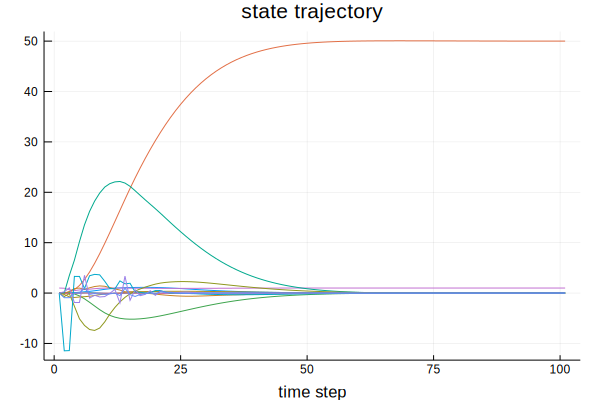

In [9]:
plot(prob.X,xlabel="time step",legend=:none,title="state trajectory")

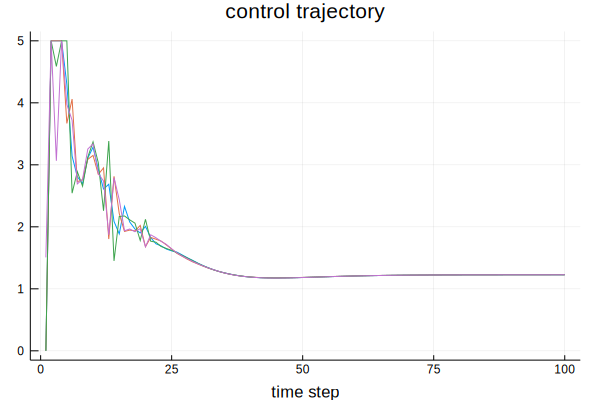

In [10]:
plot(prob.U,xlabel="time step",legend=:none,title="control trajectory")